<a href="https://colab.research.google.com/github/shivamsinghtomar78/ML-Projects-/blob/main/BCCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install required libraries
!pip install ultralytics
!pip install pyyaml
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
!git clone https://github.com/Shenggan/BCCD_Dataset.git

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800 (from 1)
Receiving objects: 100% (800/800), 7.39 MiB | 12.84 MiB/s, done.
Resolving deltas: 100% (378/378), done.


In [3]:
import os
import yaml
import shutil
from pathlib import Path
import random
import cv2
import numpy as np
from ultralytics import YOLO
from google.colab import drive
import albumentations as A

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATASET_PATH = Path("BCCD_Dataset")
OUTPUT_PATH = Path("bccd_yolo_dataset")
FINAL_MODEL_PATH = Path("/content/drive/MyDrive/bccd_model")

In [6]:
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(OUTPUT_PATH / 'images' / 'train', exist_ok=True)
os.makedirs(OUTPUT_PATH / 'images' / 'val', exist_ok=True)
os.makedirs(OUTPUT_PATH / 'images' / 'test', exist_ok=True)
os.makedirs(OUTPUT_PATH / 'labels' / 'train', exist_ok=True)
os.makedirs(OUTPUT_PATH / 'labels' / 'val', exist_ok=True)
os.makedirs(OUTPUT_PATH / 'labels' / 'test', exist_ok=True)
os.makedirs(FINAL_MODEL_PATH, exist_ok=True)

In [7]:
class_names = ["RBC", "WBC", "Platelets"]

In [8]:
# Create YAML configuration file
data_yaml = {
    'path': str(OUTPUT_PATH.absolute()),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': len(class_names),
    'names': class_names
}

In [9]:
with open(OUTPUT_PATH / 'data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

In [10]:
# Function to convert VOC XML to YOLO format
def convert_voc_to_yolo(xml_file, image_width, image_height):
    from xml.etree import ElementTree as ET

    tree = ET.parse(xml_file)
    root = tree.getroot()

    yolo_lines = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name in class_names:
            class_id = class_names.index(class_name)

            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            # Convert to YOLO format (center_x, center_y, width, height), normalized
            x_center = ((xmin + xmax) / 2) / image_width
            y_center = ((ymin + ymax) / 2) / image_height
            width = (xmax - xmin) / image_width
            height = (ymax - ymin) / image_height

            yolo_lines.append(f"{class_id} {x_center} {y_center} {width} {height}")

    return yolo_lines

In [11]:
# Process and split the dataset
def process_dataset():
    # Get all image files
    all_images = list((DATASET_PATH / "BCCD" / "JPEGImages").glob("*.jpg"))

    # Shuffle images
    random.shuffle(all_images)

    # Split (70% train, 20% val, 10% test)
    split_train = int(0.7 * len(all_images))
    split_val = int(0.9 * len(all_images))

    train_images = all_images[:split_train]
    val_images = all_images[split_train:split_val]
    test_images = all_images[split_val:]

    # Process each split
    for img_path in train_images:
        process_image(img_path, "train")

    for img_path in val_images:
        process_image(img_path, "val")

    for img_path in test_images:
        process_image(img_path, "test")

    print(f"Processed {len(train_images)} training images")
    print(f"Processed {len(val_images)} validation images")
    print(f"Processed {len(test_images)} test images")

In [12]:
# Process individual images
def process_image(img_path, split):
    img_name = img_path.name
    img_stem = img_path.stem

    # Read image to get dimensions
    img = cv2.imread(str(img_path))
    h, w, _ = img.shape

    # Find corresponding XML
    xml_path = DATASET_PATH / "BCCD" / "Annotations" / f"{img_stem}.xml"

    if not xml_path.exists():
        print(f"Warning: No XML found for {img_name}")
        return

    # Convert annotations
    yolo_lines = convert_voc_to_yolo(xml_path, w, h)

    if not yolo_lines:
        print(f"Warning: No valid annotations found for {img_name}")
        return

    # Copy image
    shutil.copy(img_path, OUTPUT_PATH / 'images' / split / img_name)

    # Save YOLO format labels
    with open(OUTPUT_PATH / 'labels' / split / f"{img_stem}.txt", 'w') as f:
        f.write('\n'.join(yolo_lines))



In [13]:
# Data Augmentation
def apply_augmentations():
    print("Applying data augmentation to training set...")

    # Define augmentation pipeline
    transform = A.Compose([
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomCrop(height=416, width=416, p=0.3),
        A.Resize(640, 640)  # Resize back to standard size
    ])

    train_images = list((OUTPUT_PATH / 'images' / 'train').glob("*.jpg"))
    augmented_count = 0

    for img_path in train_images:
        img_stem = img_path.stem
        label_path = OUTPUT_PATH / 'labels' / 'train' / f"{img_stem}.txt"

        if not label_path.exists():
            continue

        # Read image and labels
        image = cv2.imread(str(img_path))
        with open(label_path, 'r') as f:
            yolo_labels = f.read().strip().split('\n')

        # Only augment some images (to avoid too much augmentation)
        if random.random() < 0.7:
            # Create augmented version
            augmented = transform(image=image)
            aug_image = augmented['image']

            # Save augmented image
            aug_name = f"{img_stem}_aug_{augmented_count}.jpg"
            cv2.imwrite(str(OUTPUT_PATH / 'images' / 'train' / aug_name), aug_image)

            # Copy the same labels for now (this is a simplification - ideally we would transform the boxes too)
            with open(OUTPUT_PATH / 'labels' / 'train' / f"{img_stem}_aug_{augmented_count}.txt", 'w') as f:
                f.write('\n'.join(yolo_labels))

            augmented_count += 1

    print(f"Created {augmented_count} augmented images")


In [14]:
# Function for inference on a single image
def preprocess_image_for_inference(image_path, target_size=(640, 640)):
    """
    Preprocess an image for YOLOv10 inference.

    Args:
        image_path: Path to the image file
        target_size: Tuple of (width, height) for resizing

    Returns:
        Preprocessed image
    """
    # Read the image
    if isinstance(image_path, str):
        img = cv2.imread(image_path)
    else:
        img = image_path

    # Resize to target size
    img = cv2.resize(img, target_size)

    return img

def perform_inference(model_path, image):
    """
    Perform inference on an image using the fine-tuned YOLOv10 model.

    Args:
        model_path: Path to the trained model
        image: Image to perform inference on (either path or numpy array)

    Returns:
        Inference results
    """
    # Load the model
    model = YOLO(model_path)

    # Preprocess the image if it's a path
    if isinstance(image, str):
        image = preprocess_image_for_inference(image)

    # Perform inference
    results = model.predict(image, conf=0.25)

    return results

Processing dataset...
Processed 254 training images
Processed 73 validation images
Processed 37 test images
Applying data augmentation to training set...
Created 180 augmented images
Training YOLOv10 model...


100%|██████████| 5.59M/5.59M [00:00<00:00, 113MB/s]


Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=bccd_yolo_dataset/data.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

100%|██████████| 755k/755k [00:00<00:00, 23.5MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 96.1MB/s]


AMP: checks passed ✅


train: Scanning /content/bccd_yolo_dataset/labels/train... 434 images, 0 backgrounds, 0 corrupt: 100%|██████████| 434/434 [00:00<00:00, 2052.52it/s]

train: New cache created: /content/bccd_yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/bccd_yolo_dataset/labels/val... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<00:00, 1181.64it/s]

val: New cache created: /content/bccd_yolo_dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.35G       3.23      6.662      3.347         44        640: 100%|██████████| 28/28 [00:10<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all         73        926     0.0198      0.644      0.275      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.38G      3.019       4.61      2.959         53        640: 100%|██████████| 28/28 [00:08<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]

                   all         73        926       0.62      0.355        0.3      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.39G      2.903      3.982      2.873         31        640: 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.70it/s]

                   all         73        926     0.0183      0.552      0.199       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.41G      2.911      3.795       2.86         30        640: 100%|██████████| 28/28 [00:09<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]

                   all         73        926      0.842      0.335      0.532      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.42G      2.778      3.478      2.756         43        640: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]

                   all         73        926      0.477      0.055      0.147     0.0658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.44G      2.712      3.311      2.715         40        640: 100%|██████████| 28/28 [00:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         73        926      0.586      0.682      0.657        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.61G      2.725      3.307      2.714         27        640: 100%|██████████| 28/28 [00:09<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]

                   all         73        926      0.293      0.698      0.456      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.62G      2.754      3.276      2.758         42        640: 100%|██████████| 28/28 [00:09<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]

                   all         73        926      0.571      0.438      0.546      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.63G      2.759      3.337      2.747         33        640: 100%|██████████| 28/28 [00:07<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.80it/s]

                   all         73        926      0.728      0.684       0.76      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.65G      2.725      3.295      2.759         66        640: 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]

                   all         73        926      0.711      0.786      0.798      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.66G      2.711      3.112      2.726         37        640: 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.62it/s]

                   all         73        926       0.71      0.637      0.711      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.68G      2.732      3.227      2.768         81        640: 100%|██████████| 28/28 [00:08<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]

                   all         73        926      0.634      0.878      0.757      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       3.7G      2.685      2.985      2.692         38        640: 100%|██████████| 28/28 [00:08<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.46it/s]

                   all         73        926       0.67      0.753      0.758      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.71G      2.662      3.034      2.692         57        640: 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]

                   all         73        926      0.679      0.623      0.669      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.73G      2.611      2.825      2.649         31        640: 100%|██████████| 28/28 [00:09<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

                   all         73        926       0.73      0.785        0.8      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.75G      2.658      2.975      2.676         24        640: 100%|██████████| 28/28 [00:09<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

                   all         73        926      0.691      0.766      0.771      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.76G      2.681      2.934      2.663         76        640: 100%|██████████| 28/28 [00:08<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]

                   all         73        926      0.694      0.732       0.76      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.77G      2.566      2.874      2.627         38        640: 100%|██████████| 28/28 [00:09<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]

                   all         73        926      0.725      0.792      0.826      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.79G      2.598      2.833      2.647         26        640: 100%|██████████| 28/28 [00:08<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


                   all         73        926      0.735      0.772      0.823      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       3.8G       2.57      2.841      2.637         28        640: 100%|██████████| 28/28 [00:08<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]

                   all         73        926      0.785      0.271       0.55      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.82G      2.541      2.663      2.583         36        640: 100%|██████████| 28/28 [00:09<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.69it/s]

                   all         73        926      0.748      0.826      0.841      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.84G      2.538      2.772      2.597         28        640: 100%|██████████| 28/28 [00:09<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]

                   all         73        926      0.736      0.823      0.816      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.85G      2.533      2.697      2.605         55        640: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


                   all         73        926      0.782      0.765      0.821      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.87G      2.555      2.828      2.619         18        640: 100%|██████████| 28/28 [00:09<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

                   all         73        926      0.749      0.836      0.835      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.88G      2.584      2.782      2.616         35        640: 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]

                   all         73        926      0.773       0.73      0.811      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       3.9G        2.6      2.739      2.632         86        640: 100%|██████████| 28/28 [00:09<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         73        926      0.754      0.824      0.832      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.91G      2.454      2.567      2.552         44        640: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.62it/s]

                   all         73        926       0.74      0.806      0.813      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.93G      2.501      2.624      2.561         27        640: 100%|██████████| 28/28 [00:09<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]

                   all         73        926      0.748      0.798      0.826      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.94G      2.476      2.581      2.537         47        640: 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.73it/s]

                   all         73        926      0.784      0.725      0.817      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.11G      2.439      2.511      2.538         44        640: 100%|██████████| 28/28 [00:08<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

                   all         73        926      0.747      0.823      0.843      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.13G      2.479      2.642      2.591         28        640: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

                   all         73        926       0.78      0.838      0.842      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.14G      2.508      2.689      2.573         38        640: 100%|██████████| 28/28 [00:09<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]

                   all         73        926      0.769      0.795      0.851      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.16G      2.476       2.57      2.585         50        640: 100%|██████████| 28/28 [00:09<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]

                   all         73        926       0.75      0.862      0.845      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.17G      2.413       2.45      2.526         33        640: 100%|██████████| 28/28 [00:08<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]

                   all         73        926      0.724      0.878       0.84      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.19G      2.447      2.538      2.542         50        640: 100%|██████████| 28/28 [00:09<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.74it/s]

                   all         73        926      0.766      0.807      0.842      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       4.2G      2.382      2.426      2.505         44        640: 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]

                   all         73        926      0.767      0.833      0.846        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.22G      2.412      2.508      2.508         51        640: 100%|██████████| 28/28 [00:08<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         73        926       0.73      0.842      0.853      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.23G      2.388      2.452      2.497         42        640: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.69it/s]

                   all         73        926      0.751      0.846       0.85      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.25G      2.401      2.485      2.534         24        640: 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.91it/s]

                   all         73        926      0.801      0.853      0.854      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.27G      2.379      2.435      2.526         84        640: 100%|██████████| 28/28 [00:09<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]

                   all         73        926       0.79      0.828      0.861      0.609


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.29G      2.464      2.813      2.676         25        640: 100%|██████████| 28/28 [00:09<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

                   all         73        926      0.762      0.821      0.849      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       4.3G      2.429       2.69      2.678         29        640: 100%|██████████| 28/28 [00:07<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.78it/s]

                   all         73        926      0.751      0.872      0.843      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.31G      2.388      2.643      2.636         31        640: 100%|██████████| 28/28 [00:10<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

                   all         73        926      0.796      0.765      0.834       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.33G      2.357      2.575      2.617         36        640: 100%|██████████| 28/28 [00:08<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.76it/s]

                   all         73        926      0.759      0.847      0.848      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.34G      2.343      2.573      2.605         28        640: 100%|██████████| 28/28 [00:07<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         73        926      0.781      0.829       0.85      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.36G      2.311      2.521      2.577         34        640: 100%|██████████| 28/28 [00:08<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.70it/s]

                   all         73        926      0.759       0.85      0.846      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.37G      2.351      2.511      2.604         29        640: 100%|██████████| 28/28 [00:09<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]

                   all         73        926      0.786      0.847      0.853      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.39G      2.327      2.566      2.592         34        640: 100%|██████████| 28/28 [00:07<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


                   all         73        926      0.779      0.872       0.85      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       4.4G      2.272      2.457      2.561         26        640: 100%|██████████| 28/28 [00:08<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]

                   all         73        926      0.804      0.842       0.85      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.42G      2.259      2.499      2.563         33        640: 100%|██████████| 28/28 [00:09<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]

                   all         73        926      0.803      0.842      0.852      0.605
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 40, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



50 epochs completed in 0.156 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 125 layers, 2,695,586 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


                   all         73        926      0.792      0.825      0.862      0.609
                   RBC         66        785      0.668      0.795      0.784      0.549
                   WBC         71         73      0.934      0.973      0.983      0.812
             Platelets         34         68      0.775      0.708      0.818      0.467
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train
Model saved to /content/drive/MyDrive/bccd_model/bccd_yolov10_best.pt
Testing inference on bccd_yolo_dataset/images/test/BloodImage_00274.jpg

0: 640x640 13 RBCs, 1 WBC, 14.7ms
Speed: 2.8ms preprocess, 14.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Inference results: 14 detections


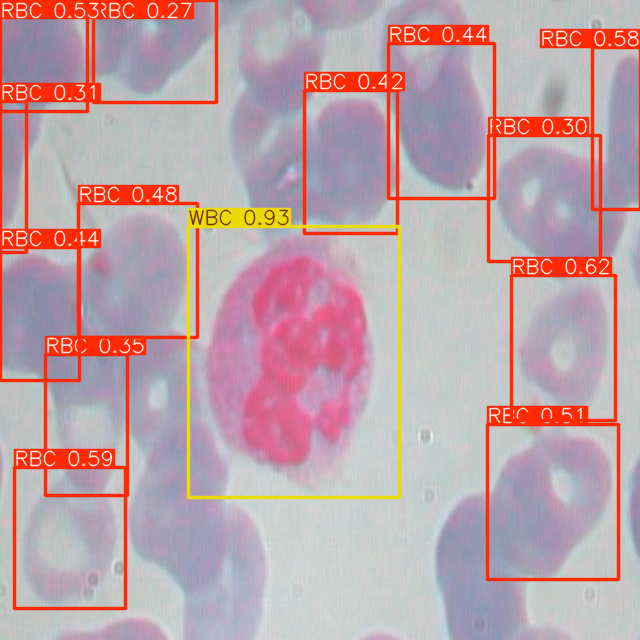

In [15]:
# Main execution logic
def main():
    # Process the dataset
    print("Processing dataset...")
    process_dataset()

    # Apply augmentations to the training set
    apply_augmentations()

    # Train YOLOv10
    print("Training YOLOv10 model...")

    # Load YOLOv10n (nano) model
    model = YOLO('yolov10n.pt')  # Alternatively use yolov10s.pt for small version

    # Train the model
    results = model.train(
        data=str(OUTPUT_PATH / 'data.yaml'),
        epochs=50,
        imgsz=640,
        batch=16,
        patience=10,
        save=True
    )

    # Save the trained model to Google Drive
    best_model_path = Path('runs/detect/train/weights/best.pt')
    if best_model_path.exists():
        shutil.copy(best_model_path, FINAL_MODEL_PATH / 'bccd_yolov10_best.pt')
        print(f"Model saved to {FINAL_MODEL_PATH / 'bccd_yolov10_best.pt'}")
    else:
        print("Warning: Best model weight file not found")

    # Test the inference function on a sample image
    test_images = list((OUTPUT_PATH / 'images' / 'test').glob("*.jpg"))
    if test_images:
        test_img = str(test_images[0])
        print(f"Testing inference on {test_img}")

        model_path = FINAL_MODEL_PATH / 'bccd_yolov10_best.pt'
        if model_path.exists():
            results = perform_inference(str(model_path), test_img)
            print(f"Inference results: {len(results[0].boxes)} detections")

            # Display results
            from PIL import Image
            from IPython.display import display

            # Get result image with boxes
            result_img = results[0].plot()
            display(Image.fromarray(result_img))
        else:
            print("Model not found. Run training first.")

if __name__ == "__main__":
    main()